In [1]:
import SimpleITK as sitk
import os
import numpy as np
from ipywidgets import interact, fixed

%matplotlib widget
import gui


# This is the registration configuration which we use in all cases. The only parameter that we vary
# is the initial_transform.
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        estimateLearningRate=registration_method.Once,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print(f"Final metric value: {registration_method.GetMetricValue()}")
    print(
        f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
    )
    return (final_transform, registration_method.GetMetricValue())

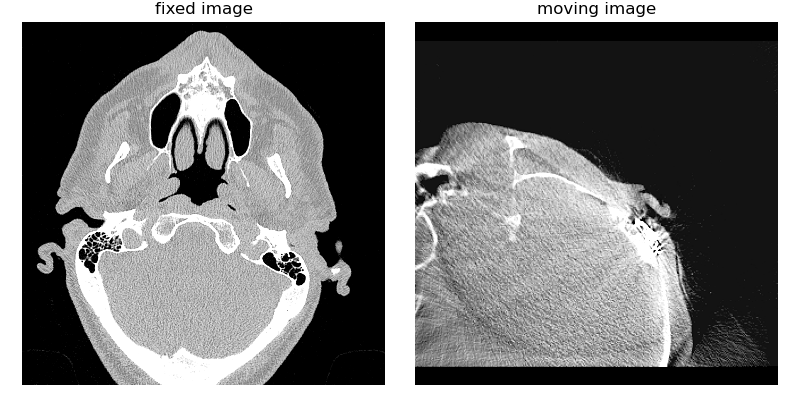

In [2]:

%matplotlib widget

# Load the images
fixed_image = sitk.ReadImage("/Users/umcai/Research/CVI_support/data/CVI11_right/preop.nrrd", sitk.sitkFloat32)
moving_image = sitk.ReadImage("/Users/umcai/Research/CVI_support/data/CVI11_right/intraop1.nrrd", sitk.sitkFloat32)
ct_window_level = [1500, -100]
gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed image", "moving image"],
    figure_size=(8, 4),
    window_level_list=[ct_window_level, ct_window_level],
    intensity_slider_range_percentile=[0, 100],
);

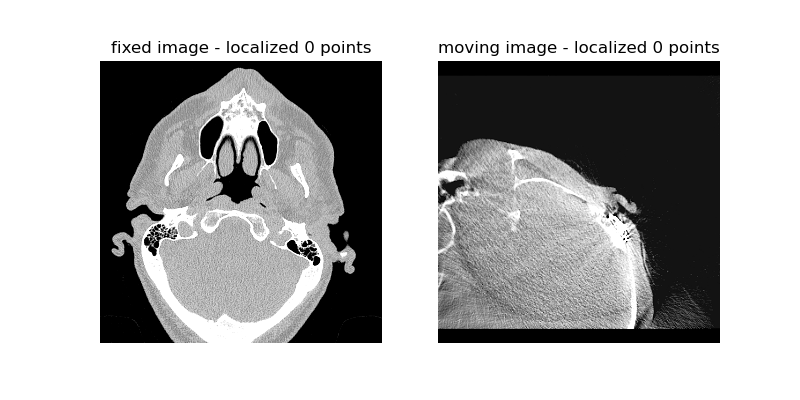

In [3]:
point_acquisition_interface = gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    fixed_window_level=ct_window_level,
    moving_window_level=ct_window_level,
);

In [4]:
# Get the manually specified points and compute the transformation.
fixed_image_points, moving_image_points = point_acquisition_interface.get_points()

# FOR TESTING: previously localized points
# fixed_image_points = [
#     (24.062587103074605, 14.594981536981521, -58.75),
#     (6.178716135332678, 53.93949766601378, -58.75),
#     (74.14383149714774, -69.04462737237648, -76.25),
#     (109.74899278747029, -14.905272533666817, -76.25),
# ]
# moving_image_points = [
#     (4.358707846364581, 60.46357110706131, -71.53120422363281),
#     (24.09010295252645, 98.21840981673873, -71.53120422363281),
#     (-52.11888008581127, -26.57984635768439, -58.53120422363281),
#     (-87.46150681392184, 28.73904765153219, -58.53120422363281),
# ]

fixed_image_points_flat = [c for p in fixed_image_points for c in p]
moving_image_points_flat = [c for p in moving_image_points for c in p]
init_transform = sitk.VersorRigid3DTransform(
    sitk.LandmarkBasedTransformInitializer(
        sitk.VersorRigid3DTransform(), fixed_image_points_flat, moving_image_points_flat
    )
)
# Convert from Versor to Euler, as Versor does not always work well with the optimization.
# Internally the optimization sets new parameter values without any constraints, and the versor
# normalizes its vector component if it is greater than 1-epsilon.
initial_transform = sitk.Euler3DTransform()
initial_transform.SetCenter(init_transform.GetCenter())
initial_transform.SetMatrix(init_transform.GetMatrix())
initial_transform.SetTranslation(init_transform.GetTranslation())
print("manual initial transformation is: " + str(initial_transform.GetParameters()))

manual initial transformation is: (0.14896728286653318, -0.057403133882523466, 0.5850060855059596, -36.70900537634415, 336.4186827956988, -1328.425)


Final metric value: -0.4062153529363509
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 47.


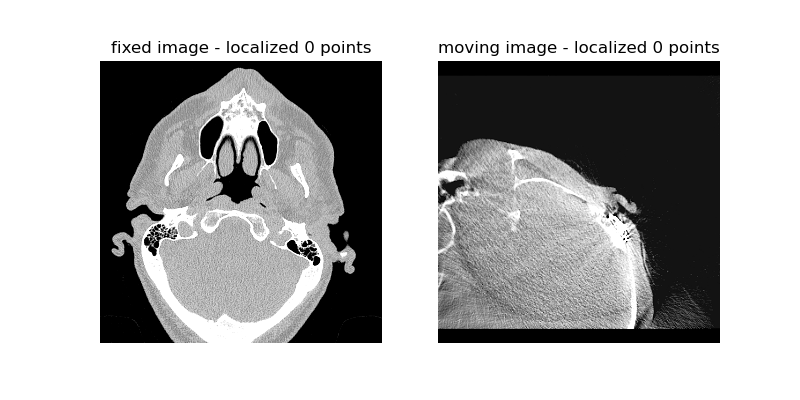

In [5]:
final_transform, _ = multires_registration(fixed_image, moving_image, initial_transform)
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=ct_window_level,
);